Connected to Python 3.14.0

Population      → 17290 rows, 65 years
GDP per capita  → 17290 rows, 65 years
Agriculture     → 17290 rows, 65 years
Services        → 17290 rows, 65 years
Internet        → 17290 rows, 65 years
Mobile          → 17290 rows, 65 years
Population      → 17,290 rows | 65 years (from 1960 to 2024)
GDP per capita  → 17,290 rows | 65 years (from 1960 to 2024)
Agriculture     → 17,290 rows | 65 years (from 1960 to 2024)
Services        → 17,290 rows | 65 years (from 1960 to 2024)
Internet        → 17,290 rows | 65 years (from 1960 to 2024)
Mobile          → 17,290 rows | 65 years (from 1960 to 2024)
Rows: 17,290
Countries: 266 | Years: 65 (1960–2024)

Share missing (0–1) for key variables:
                share_missing
pop                  0.005495
gdp_pc               0.158994
mobile_subs          0.257201
agr_share            0.354540
srv_share            0.392366
internet_users       0.610295
Rows after filtering: 8,515
Countries: 131 | Years: 65 (1960–2024)


<ipython-input-1-6c68a3e69603>:151: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change() * 100


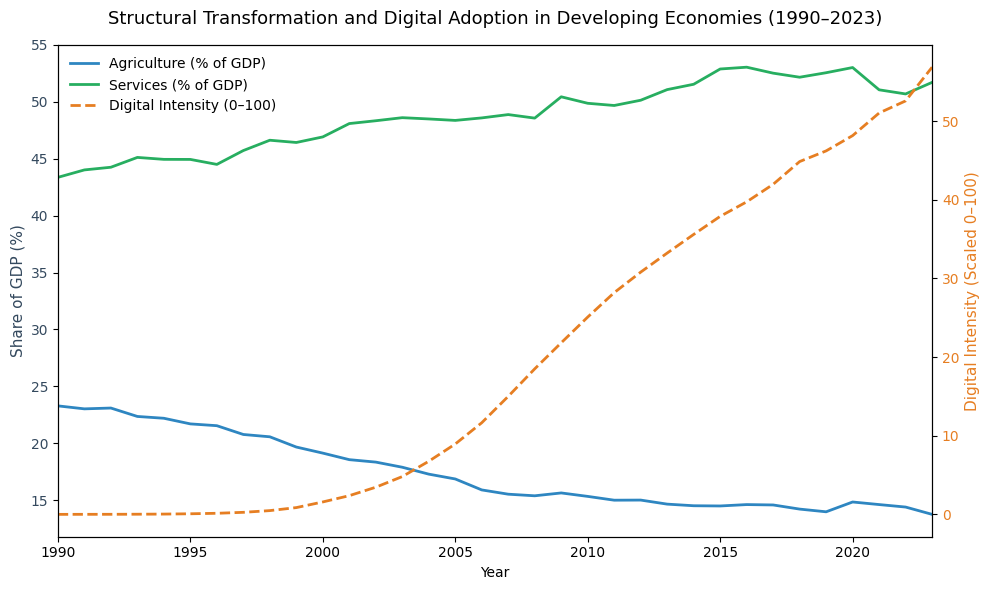

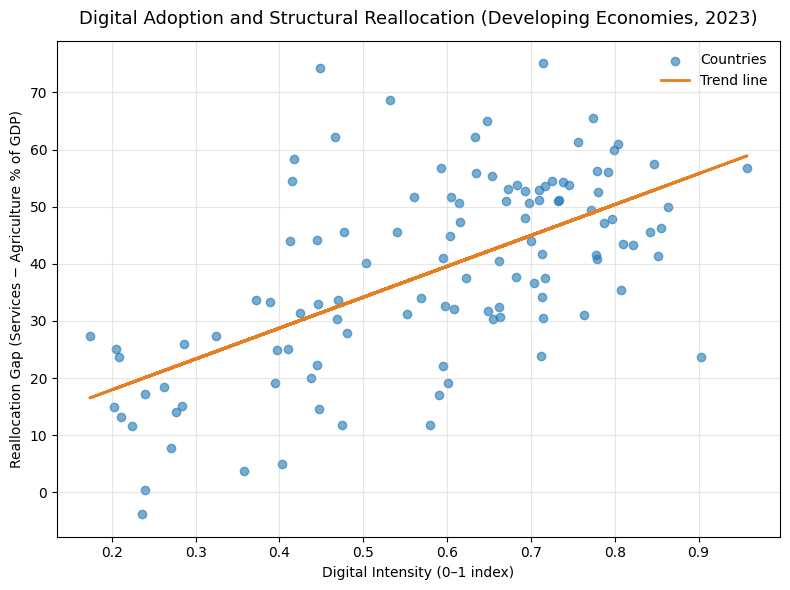

<ipython-input-1-6c68a3e69603>:246: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_latest = df_dev[df["year"] == latest_year].dropna(subset=["population", "mobile_subscriptions", "services_share_gdp"])


KeyError: ['population', 'mobile_subscriptions', 'services_share_gdp']

<Figure size 1000x600 with 0 Axes>

In [ ]:
#Import World Bank Data

import pandas as pd

# Define data folder
RAW_DIR = "data/raw"

# Function to read and reshape World Bank CSVs
def read_wb_api_csv(path, value_name):
    df = pd.read_csv(path, skiprows=4)
    df = df.rename(columns={"Country Name": "country", "Country Code": "iso3c"})
    year_cols = [c for c in df.columns if c.isdigit()]
    df = df.melt(id_vars=["country", "iso3c"], value_vars=year_cols,
                 var_name="year", value_name=value_name)
    df["year"] = df["year"].astype(int)
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    return df

# Load all required indicators
pop = read_wb_api_csv(f"{RAW_DIR}/API_SP.POP.TOTL_DS2_en_csv_v2_130083.csv", "pop")
gdp_pc = read_wb_api_csv(f"{RAW_DIR}/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_134819.csv", "gdp_pc")
agr = read_wb_api_csv(f"{RAW_DIR}/API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_128624.csv", "agr_share")
srv = read_wb_api_csv(f"{RAW_DIR}/API_NV.SRV.TOTL.ZS_DS2_en_csv_v2_129290.csv", "srv_share")
net = read_wb_api_csv(f"{RAW_DIR}/API_IT.NET.USER.ZS_DS2_en_csv_v2_129784.csv", "internet_users")
mob = read_wb_api_csv(f"{RAW_DIR}/API_IT.CEL.SETS.P2_DS2_en_csv_v2_123929.csv", "mobile_subs")

# Quick check
for name, d in {"Population": pop, "GDP per capita": gdp_pc, "Agriculture": agr,
                "Services": srv, "Internet": net, "Mobile": mob}.items():
    print(f"{name:15} → {d.shape[0]} rows, {d['year'].nunique()} years")


# Basic Cleaning 
YEARS = list(range(1990, 2024))

# Ensure numeric values, Keep only the years we want 
for df in [pop, gdp_pc, agr, srv, net, mob]:
    df = df[df["year"].isin(YEARS)].copy()
    value_col = df.columns[-1]
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

    datasets = {
    "Population": pop,
    "GDP per capita": gdp_pc,
    "Agriculture": agr,
    "Services": srv,
    "Internet": net,
    "Mobile": mob
}

for name, df in datasets.items():
    years = df["year"].unique()
    print(f"{name:15} → {len(df):6,} rows | {df['year'].nunique():2} years "
          f"(from {years.min()} to {years.max()})")



# merge datasets on country, iso3c, year
df = pop.merge(gdp_pc, on=["country", "iso3c", "year"], how="outer") \
        .merge(agr,     on=["country", "iso3c", "year"], how="outer") \
        .merge(srv,     on=["country", "iso3c", "year"], how="outer") \
        .merge(net,     on=["country", "iso3c", "year"], how="outer") \
        .merge(mob,     on=["country", "iso3c", "year"], how="outer")

# Tidy column order
first_cols = ["country", "iso3c", "year"]
df = df[first_cols + [c for c in df.columns if c not in first_cols]]

# checks
print(f"Rows: {len(df):,}")
print(f"Countries: {df['iso3c'].nunique()} | Years: {df['year'].nunique()} "
      f"({df['year'].min()}–{df['year'].max()})")

# Share missing for key variables (0-1)
key_vars = ["pop","gdp_pc","agr_share","srv_share","internet_users","mobile_subs"]
missing = df[key_vars].isna().mean().sort_values().to_frame("share_missing")
print("\nShare missing (0–1) for key variables:")
print(missing)

# Peek 
df.head()

# Create df_dev for developing countries

meta_path = "data/raw/Metadata_Country_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_134819.csv"
meta = pd.read_csv(meta_path, encoding="utf-8", engine="python")

# Keep the key columns and rename
meta = meta.rename(columns={
    "Country Code": "iso3c",
    "Region": "region",
    "IncomeGroup": "income_group"
})[["iso3c", "region", "income_group"]]

# Merge the metadata into our main DataFrame
df = df.merge(meta, on="iso3c", how="left")

# Drop rows where region is missing
df = df[df["region"].notna()].copy()

# Clean income group text
df["income_group"] = (
    df["income_group"]
    .astype(str)
    .str.strip()
    .str.replace("_", " ", regex=False)
    .str.title()
)

# Exclude High-income economies
df_dev = df[df["income_group"] != "High Income"].copy()

# Results
print(f"Rows after filtering: {len(df_dev):,}")
print(f"Countries: {df_dev['iso3c'].nunique()} | Years: {df_dev['year'].nunique()} ({df_dev['year'].min()}–{df_dev['year'].max()})")
df_dev["income_group"].value_counts()

# preview
df.head(10)


# 3) Creating new variables 
import numpy as np

# Normalise digital indicators (0–1 range) to make them comparable
for var in ["internet_users", "mobile_subs"]:
    df_dev[var + "_norm"] = (
        (df_dev[var] - df_dev[var].min()) /
        (df_dev[var].max() - df_dev[var].min())
    )

# Combined digital adoption index
df_dev["digital_intensity"] = df_dev[["internet_users_norm", "mobile_subs_norm"]].mean(axis=1)

# Log GDP per capita 
df_dev["log_gdp_pc"] = np.log(df_dev["gdp_pc"])

# Services Ratio to Agriculture
df_dev["service_ratio"] = (
    df_dev["srv_share"] /
    (df_dev["srv_share"] + df_dev["agr_share"])
)
# Reallocation gap
df_dev["realloc_gap"] = df_dev["srv_share"] - df_dev["agr_share"]

# Digital adoption growth rate (year-on-year % change per country)

df_dev = df_dev.sort_values(["country", "year"])
df_dev["digital_growth"] = (
    df_dev.groupby("country")["digital_intensity"]
          .pct_change() * 100
)


# Total GDP (current US$)
df_dev["gdp_total_usd"] = df_dev["pop"] * df_dev["gdp_pc"]

# Agriculture GDP (current US$)
df_dev["agri_gdp_usd"] = df_dev["gdp_total_usd"] * (df_dev["agr_share"] / 100)

# Services GDP (current US$)
df_dev["services_gdp_usd"] = df_dev["gdp_total_usd"] * (df_dev["srv_share"] / 100)

# Preview
df_dev[df_dev["year"] == 2005]




# Plot 1 - Average Structural Change and Digital Adoption
import matplotlib.pyplot as plt

# Compute yearly averages and restrict to 1990–2023
trend = (
    df_dev.groupby("year")[["agr_share", "srv_share", "digital_intensity"]]
          .mean()
          .reset_index()
)
trend = trend[trend["year"].between(1990, 2023)]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10,6))

# Left axis 
ax1.plot(trend["year"], trend["agr_share"], label="Agriculture (% of GDP)", 
         color="#2E86C1", linewidth=2)
ax1.plot(trend["year"], trend["srv_share"], label="Services (% of GDP)", 
         color="#27AE60", linewidth=2)
ax1.set_ylabel("Share of GDP (%)", fontsize=11, color="#34495E")
ax1.tick_params(axis="y", labelcolor="#34495E")
ax1.set_xlim(1990, 2023)

# Right axis 
ax2 = ax1.twinx()
ax2.plot(trend["year"], trend["digital_intensity"]*100, 
         label="Digital Intensity (0–100)", 
         color="#E67E22", linestyle="--", linewidth=2)
ax2.set_ylabel("Digital Intensity (Scaled 0–100)", fontsize=11, color="#E67E22")
ax2.tick_params(axis="y", labelcolor="#E67E22")

# Titles and layout
plt.title("Structural Transformation and Digital Adoption in Developing Economies (1990–2023)",
          fontsize=13, pad=15)
ax1.set_xlabel("Year")
fig.tight_layout()

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", frameon=False)

plt.show()



# Plot 2 - Digital Adoption vs Reallocation Gap (Developing Economies, 2023)
import matplotlib.pyplot as plt
import numpy as np

# Filter for latest year with valid values
df_latest = df_dev[df_dev["year"] == 2023].dropna(subset=["digital_intensity", "realloc_gap"])

x = df_latest["digital_intensity"]
y = df_latest["realloc_gap"]

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, color="#1f77b4", label="Countries")

# Simple OLS trend line
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="#e67e22", linewidth=2, label="Trend line")

plt.title("Digital Adoption and Structural Reallocation (Developing Economies, 2023)", fontsize=13, pad=12)
plt.xlabel("Digital Intensity (0–1 index)")
plt.ylabel("Reallocation Gap (Services − Agriculture % of GDP)")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))

# Filter for most recent year with minimal missing values
latest_year = df["year"].max()
df_latest = df_dev[df["year"] == latest_year].dropna(subset=["population", "mobile_subscriptions", "services_share_gdp"])

plt.scatter(df_latest["population"], 
            df_latest["mobile_subscriptions"], 
            s=df_latest["services_share_gdp"]*3,  # bubble size scaled by services share
            alpha=0.6, edgecolor="k")

plt.xscale("log")
plt.title(f"Population vs. Mobile Subscriptions ({latest_year})")
plt.xlabel("Population (log scale)")
plt.ylabel("Mobile Subscriptions (per 100 people)")
plt.text(df_latest["population"].max()/2, 
         df_latest["mobile_subscriptions"].max()*0.9,
         "Bubble size = Services share of GDP", fontsize=9, color="gray")
plt.tight_layout()
plt.show()